# Plotting

In this notebook we will show how you can use CARLA to visualize your results. First, we need to load some factuals, and generate counterfactuals for them. For more explanation on how to do this, please take a look at our [How to use CARLA](https://carla-counterfactual-and-recourse-library.readthedocs.io/en/chore-update_documentation/notebooks/how_to_use_carla.html) notebook.

In [1]:
from carla.plotting.plotting import summary_plot, single_sample_plot
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


## Generating counterfactuals

Before we can plot anything, we need to generate counterfactuals. So we get some factuals, a classification model, a recourse model, and we let it run.

In [2]:
data_name = "adult"
dataset = OnlineCatalog(data_name)

In [3]:
# load catalog model
model_type = "ann"
ml_model = MLModelCatalog(
    dataset,
    model_type=model_type,
    load_online=True,
    backend="pytorch"
)

In [4]:
hyperparams = {
        "data_name": data_name,
        "n_search_samples": 100,
        "p_norm": 1,
        "step": 0.1,
        "max_iter": 1000,
        "clamp": True,
        "binary_cat_features": True,
        "vae_params": {
            "layers": [len(ml_model.feature_input_order), 512, 256, 8],
            "train": True,
            "lambda_reg": 1e-6,
            "epochs": 5,
            "lr": 1e-3,
            "batch_size": 32,
        },
    }

# define your recourse method
recourse_method = recourse_catalog.CCHVAE(ml_model, hyperparams)

[INFO] Start training of Variational Autoencoder... [models.py fit]
[INFO] [Epoch: 0/5] [objective: 0.365] [models.py fit]
[INFO] [ELBO train: 0.36] [models.py fit]
[INFO] [ELBO train: 0.13] [models.py fit]
[INFO] [ELBO train: 0.12] [models.py fit]
[INFO] [ELBO train: 0.12] [models.py fit]
[INFO] [ELBO train: 0.12] [models.py fit]
[INFO] ... finished training of Variational Autoencoder. [models.py fit]


In [5]:
# get some negative instances
factuals = predict_negative_instances(ml_model, dataset.df)
factuals = factuals[:100]

# find counterfactuals
counterfactuals = recourse_method.get_counterfactuals(factuals)

## Plotting

In the above section we got a dataset from the OnlineCatalog, and generated counterfactuals for a subset of that data. However sometimes it happens that recourse is not succesfull, which is a problem when plotting. So before we do any plotting we first need to do some pre-processing and remove the rows for which counterfactuals could not be found.

In [6]:
# remove rows where no counterfactual was found
counterfactuals = counterfactuals.dropna()
factuals = factuals[factuals.index.isin(counterfactuals.index)]

### Single sample plot

The first possibility when plotting is for single samples. This plot is a horizontal bar plot, and is useful for visualizing which features are important for a single sample. The feature names are shown on the y-axis. The x-axis shows the difference between the counterfactual and the factual for that particular feature. Blue indicated a negative change, while red indicates a positive change. For example, `education-num` is lower in the counterfactual then it is in the factual, while `hours-per-week` is higher.

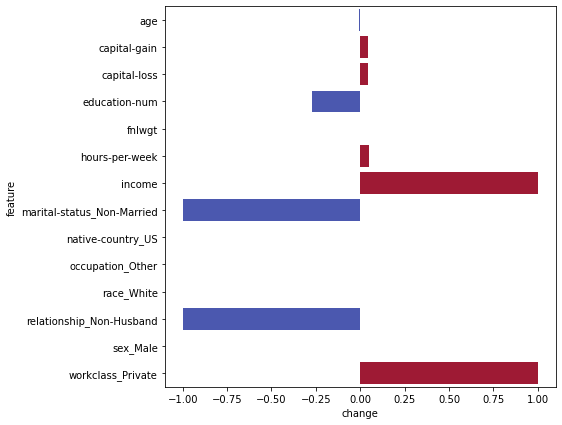

In [10]:
single_sample_plot(factuals.iloc[0], counterfactuals.iloc[0])

### Summary plot

The second possibility is a summary plot, which is useful to visualize a large number of samples. Again the y-axis shows the features, while the x-axis shows the difference. However here the color coding corresponds to the original feature-value, not positive or negative change. So red means high original feature-value, blue low original feature-value. The plots show the top-n most important features, which is measured by their total absolute change.

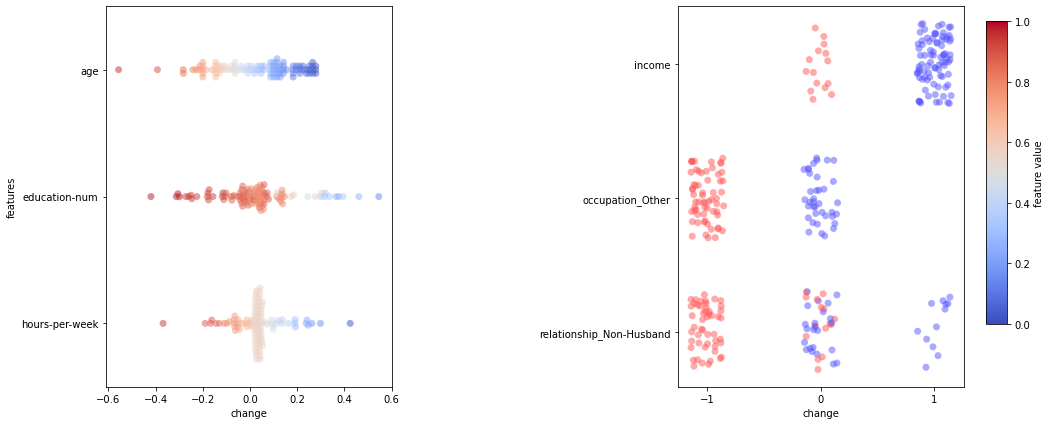

In [20]:
summary_plot(factuals, counterfactuals, dataset, topn=3)